# Data sorting
Make a train, validation and test data folders

In [1]:
'''
loading libs
'''
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os, shutil 

original_dataset_path = './data'

base_path = './melanoma_nevus'
if not os.path.isdir(base_path): os.mkdir(base_path)

# Make a new folders
train_folder = os.path.join(base_path, 'train')
if not os.path.isdir(train_folder): os.mkdir(train_folder)
validation_folder = os.path.join(base_path, 'validation')
if not os.path.isdir(validation_folder): os.mkdir(validation_folder)
test_folder = os.path.join(base_path, 'test')
if not os.path.isdir(test_folder): os.mkdir(test_folder)

train_melanoma_folder = os.path.join(train_folder, 'melanoma')
if not os.path.isdir(train_melanoma_folder): os.mkdir(train_melanoma_folder)
train_nevus_folder = os.path.join(train_folder, 'nevus')
if not os.path.isdir(train_nevus_folder): os.mkdir(train_nevus_folder)


validation_melanoma_folder = os.path.join(validation_folder, 'melanoma')
if not os.path.isdir(validation_melanoma_folder): os.mkdir(validation_melanoma_folder)
validation_nevus_folder = os.path.join(validation_folder, 'nevus')
if not os.path.isdir(validation_nevus_folder): os.mkdir(validation_nevus_folder)

test_melanoma_folder = os.path.join(test_folder, 'melanoma')
if not os.path.isdir(test_melanoma_folder): os.mkdir(test_melanoma_folder)
test_nevus_folder = os.path.join(test_folder, 'nevus')
if not os.path.isdir(test_nevus_folder): os.mkdir(test_nevus_folder)

In [3]:
# Get filenames for melanoma and nevus
melanoma_path = os.path.join(original_dataset_path, '1')
nevus_path = os.path.join(original_dataset_path, '0')

melanoma_filenames = [f for f in os.listdir(melanoma_path) if os.path.isfile(os.path.join(melanoma_path, f))]
nevus_filenames = [f for f in os.listdir(nevus_path) if os.path.isfile(os.path.join(nevus_path, f))]

In [4]:
def save_processed_files(src_dst):
    img = image.load_img(src_dst[0])
    y = preprocess(np.array(img))
    image.save_img(src_dst[1],y)
    

# Copy images in to new folders
# split ratio (train, validation, test)
split_ratio = (0.7, 0.2, 0.1)

melanoma_src_dst = []
print("Melanoma files: {}".format(len(melanoma_filenames)))
for i in range(len(melanoma_filenames)):
    file_name = melanoma_filenames[i]
    
    src = os.path.join(melanoma_path, file_name)
    
    if i < split_ratio[0] * len(melanoma_filenames):
        # Train
        dst = os.path.join(train_melanoma_folder, file_name)
    elif i < split_ratio[0] * len(melanoma_filenames) + split_ratio[1] * len(melanoma_filenames):
        # Validation
        dst = os.path.join(validation_melanoma_folder, file_name)
    else:
        # Test
        dst = os.path.join(test_melanoma_folder, file_name)
        
    shutil.copyfile(src, dst)

nevus_src_dst = []
print("Nevus files: {}".format(len(nevus_filenames)))
for i in range(len(nevus_filenames)):
    file_name = nevus_filenames[i]
    
    src = os.path.join(nevus_path, file_name)
    
    if i < split_ratio[0] * len(nevus_filenames):
        # Train
        dst = os.path.join(train_nevus_folder, file_name)
    elif i < split_ratio[0] * len(nevus_filenames) + split_ratio[1] * len(nevus_filenames):
        # Validation
        dst = os.path.join(validation_nevus_folder, file_name)
    else:
        # Test
        dst = os.path.join(test_nevus_folder, file_name)

    shutil.copyfile(src, dst)
  
print('-'*32)
print('Melanoma train:', len(os.listdir(train_melanoma_folder)))
print('Melanoma validation:', len(os.listdir(validation_melanoma_folder)))
print('Melanoma test:', len(os.listdir(test_melanoma_folder)))
print('Nevus train:', len(os.listdir(train_nevus_folder)))
print('Nevus validation:', len(os.listdir(validation_nevus_folder)))
print('Nevus test:', len(os.listdir(test_nevus_folder)))

Melanoma files: 1000
Nevus files: 1000
--------------------------------
Melanoma train: 700
Melanoma validation: 200
Melanoma test: 100
Nevus train: 700
Nevus validation: 200
Nevus test: 100


# Make image generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# SIZE = (600,450)
SIZE = (224,224)

# Datagen preprocessing_function
def preprocess(img):
    new_img = np.array(img[:,:,0]*255, dtype='uint8') 
    
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
    new_img = clahe.apply(new_img)
    img[:,:,0] = new_img
    img[:,:,1] = new_img
    img[:,:,2] = new_img
    
    return img/255#new_img.reshape(img.shape[0], img.shape[1], )

# Rescale image values from 0..255 to 0..1
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
#                                    shear_range=0.1,
#                                    zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
#                                    preprocessing_function=preprocess,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder, 
    target_size = (SIZE[0],SIZE[1]),
    batch_size = 20,
    class_mode = 'binary')

valid_generator = valid_datagen.flow_from_directory(
    validation_folder, 
    target_size = (SIZE[0],SIZE[1]), 
    batch_size = 20,
    class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (SIZE[0],SIZE[1]), 
    batch_size = 20,
    class_mode = 'binary')

Found 1400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# Network construction

In [6]:
import tensorflow

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

print(tensorflow.__version__)
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

tensorflow.debugging.set_log_device_placement(True)
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(gpus[0], True)

1.15.2
Num GPUs Available:  1


In [7]:
'''
Define plot training function
'''
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
# from tensorflow.keras_tqdm import TQDMNotebookCallback

base_model = ResNet50(weights='imagenet', include_top=False,
                     input_shape=(SIZE[0], SIZE[1], 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = MaxAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='elu')(x)
x = Dropout(0.9)(x)
# and a logistic layer
predictions = Dense(1, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = True

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5



In [9]:
from tensorflow.keras.optimizers import Adam

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy',
             metrics=['accuracy'])

In [10]:
callbacks_list = [
#     tensorflow.keras.callbacks.EarlyStopping(
#         monitor='val_acc', min_delta=0.001, patience=7),
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath='model.h5', monitor='val_loss',save_best_only=True)
]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=1400//20,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=400//20,
    callbacks=callbacks_list)

Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
70/70 [==============================] - 37s 530ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 2/50
70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 3/50
70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 4/50
70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 5/50
70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 6/50
70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 7/50
70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 

70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 37/50
70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 38/50
70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 39/50
70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 40/50
70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 41/50
70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 42/50
70/70 [==============================] - 12s 165ms/step - loss: 7.6666 - acc: 0.5000 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 43/50
70/70 [==============================] - 12s 165ms/step - loss

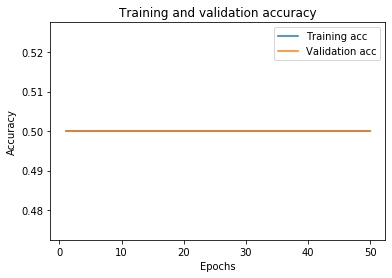

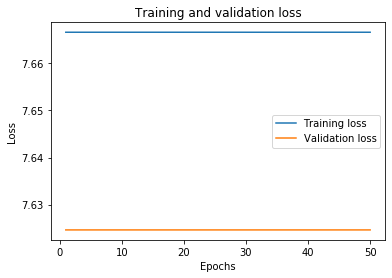

In [11]:
plot_history(history)

In [12]:
import tensorflow
from tensorflow.keras.models import load_model
model = load_model('model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
model.evaluate_generator(test_generator, 20)

[7.6246192932128904, 0.5]